In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb


# Load train and test data
df = pd.read_csv('u1.base', delimiter='\t', names=['userid', 'itemid', 'rating', 'timestamp'])
test = pd.read_csv('u1.test', delimiter='\t', names=['userid', 'itemid', 'rating', 'timestamp'])
y_train = df[['rating']]
x_test = test[['userid', 'itemid']]
y_test = test['rating']

In [2]:
import os
data_path = os.path.join('/Users/rouna/OneDrive/Desktop/Project(Prof. sobhan)/ml-100k', '')

In [3]:
df.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
x_train = df[['userid', 'itemid']]
y_train = df[['rating']]
x_test = test[['userid', 'itemid']]
y_test = test['rating']

In [5]:
# load data
user = pd.read_csv(data_path+'u.user', delimiter = '|', names = ['id', 'age', 'gender', 'occupation', 'zip'])[['id', 'age', 'gender', 'occupation']]
genre = pd.read_csv(data_path+'u.genre', delimiter = '|', names = ['genre', 'id']).genre.to_list()
occupation_col_names =  pd.read_csv(data_path+'u.occupation', delimiter = '|', names = ['occupation'])['occupation'].to_list()

# perform one-hot encoding on the user's occupation column, and label encoding on the gender column
user[occupation_col_names] = preprocessing.OneHotEncoder(sparse = False).fit_transform(user.occupation.to_numpy().reshape(-1,1))
user['gender'] = preprocessing.LabelEncoder().fit_transform(user.gender)
user = user.drop(['occupation'], axis = 1)

# notice that the genre is already in the one-hot encoding format in the movie dataset, 
# so we can simply load the movie data
item_col_names = ['movie id','movie title','release date','video release date','IMDb URL'] + genre
item = pd.read_csv(data_path+'u.item', delimiter = '|', names = item_col_names, encoding = 'latin1')[['movie id'] + genre]

# Next we merge the movie and user data with our train and test dataset
x_train = x_train.join(user.set_index('id'), on = 'userid').join(item.set_index('movie id'), on = 'itemid')
x_test = x_test.join(user.set_index('id'), on = 'userid').join(item.set_index('movie id'), on = 'itemid')

x_train.head()

c:\Users\rouna\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,userid,itemid,age,gender,administrator,artist,doctor,educator,engineer,entertainment,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1,4,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,24,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(x_train, y_train)

pred1 = model1.predict(x_test)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

content-based rmse = 0.9791159018774043


In [7]:
def compute_single_prediction(userid, itemid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    numerate = np.dot(user_rating, item_similarity)
    denom = item_similarity[user_rating > 0].sum()
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

def compute_all_prediction(test_set, pred_func, similarity_mtx, utility, **kwargs):
    pred = []
    for data in test_set:
        res = pred_func(userid = data[0], 
                        itemid = data[1], 
                        similarity_mtx = similarity_mtx, 
                        utility = utility, 
                        **kwargs)
        pred.append(res)
    return pred

In [8]:
# model 2
# construct the utility matrix
utility = df.pivot(index = 'itemid', columns = 'userid', values = 'rating')
utility = utility.fillna(0)

# calculate the similarity
similarity_mtx = 1 - squareform(pdist(utility, 'cosine'))

pred2 = compute_all_prediction(test[['userid', 'itemid']].to_numpy(),
                      compute_single_prediction,
                      similarity_mtx,
                      utility)
pred2 = np.array(pred2)

rmse = np.sqrt(np.mean((pred2 - y_test.to_numpy())**2))
print(f'rmse of item-item collaborative filtering = {rmse}')

rmse of item-item collaborative filtering = 1.0452369678411928


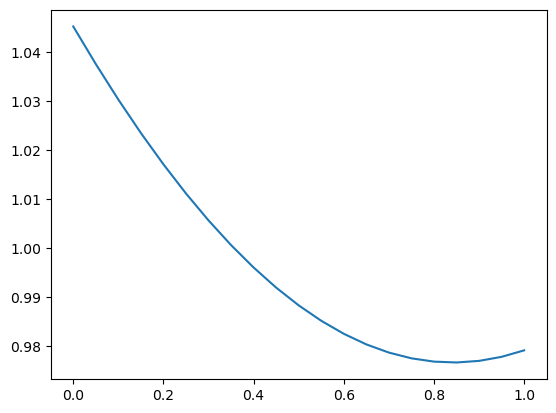

In [9]:
chart_val = []

w = np.linspace(0,1,21)

for i in w:
    pred4 = pred1*i + pred2*(1-i)
    rmse = np.sqrt(np.mean((pred4 - y_test.to_numpy())**2))
    chart_val.append([i, rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])